In [ ]:
import xml.etree.ElementTree as ET
import os as os
from PIL import Image
import numpy as np
import torch
import os
from glob import glob
import cv2
import torch
import random
import numbers
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import randperm
from torch._utils import _accumulate
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import sklearn.metrics as skm
from scipy.spatial import distance
from scipy.stats import multivariate_normal

In [2]:
class Blobdataset(Dataset):
    def __init__(self, path, Transform=None):
        self.path = path
        self.transform = Transform
        files = []
        self.filtered_files = []
        for ext in ('**/*.jpeg', '**/*.png', '**/*.jpg'):
            files.extend(glob(os.path.join(path, ext),recursive=True))   
        
        for file in files:
            ext = file.split(".")[-1]
            self.xml_path = file.replace("."+ext,".xml")            
            if os.path.isfile(self.xml_path):
                self.filtered_files.append(file)       
    def __len__(self):
        return len(self.filtered_files)
    
    def __getitem__(self, index):
        
        image_path = self.filtered_files[index]
        ext = image_path.split(".")[-1]
        xml_path = image_path.replace("."+ext,".xml")
        annotation = ET.parse(xml_path).getroot()
        image = F.to_tensor(Image.open(image_path))
        
        
#         if(self.transform):
            
#             if(type(self.transform) is not list):
#                 self.transform = [self.transform]
            
#             for idx in range(len(self.transform)):
#                 data_dict = self.transform[idx](data_dict)
        
        image_size = image.shape
        heatmap_placeholder = torch.ones([3, int(image_size[1]/4), int(image_size[2]/4)])
        
        class_flags = [False,False,False]
        for obj in annotation.findall("object"):
            
            label = obj.find("name").text
            anno_bound_box = obj.find("bndbox")
            bound_box_center = self.get_center(anno_bound_box)

            
            if(label == "ball"):
                class_flags[0] = True
                heatmap_placeholder[0] -= self.get_heatmap(image_size,bound_box_center,3)
            elif (label == "goalpost"):
                class_flags[1] = True
                heatmap_placeholder[1] -= self.get_heatmap(image_size,bound_box_center,3) 
            elif (label == "robot"):
                class_flags[2] = True
                heatmap_placeholder[2] -= self.get_heatmap(image_size,bound_box_center,10)
                
        for i in range(heatmap_placeholder.shape[0]):
            heatmap_placeholder[i] = self.get_normalized_heatmap(heatmap_placeholder[i],class_flags[i])

        return image, heatmap_placeholder
    def get_normalized_heatmap(self,heatmap_single_channel,class_flag):
        n = (heatmap_single_channel-torch.min(heatmap_single_channel))
        d = (torch.max(heatmap_single_channel)-torch.min(heatmap_single_channel))
        if class_flag:
            return n/d
        else:
            return heatmap_single_channel
    def get_center(self,bound_box):
        xmin = int(bound_box.find('xmin').text)
        ymin = int(bound_box.find('ymin').text)
        xmax = int(bound_box.find('xmax').text)
        ymax = int(bound_box.find('ymax').text)
        return (int((xmin+xmax)/2),int((ymin+ymax)/2))
    def get_heatmap(self,image_size,center_point,variance):
        new_height, new_width = int(image_size[1]/4), int(image_size[2]/4)
        #https://stackoverflow.com/questions/54726703/generating-keypoint-heatmaps-in-tensorflow
        mean = [center_point[1]/4,center_point[0]/4]
        pos = np.dstack(np.mgrid[0:new_height:1, 0:new_width:1])
        rv = multivariate_normal(mean, cov=variance)
        return variance*rv.pdf(pos).reshape(new_height,new_width)
        

In [3]:
full_dataset = Blobdataset("/home/santosh/MAS/CUDA_vision/Project/data/blob")
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
print("Total samples: ",len(full_dataset))
print("Training samples: ",len(train_dataset))
print("Validation samples: ",len(val_dataset))
print("Testing samples: ",len(test_dataset))

Total samples:  8858
Training samples:  6200
Validation samples:  1328
Testing samples:  1330


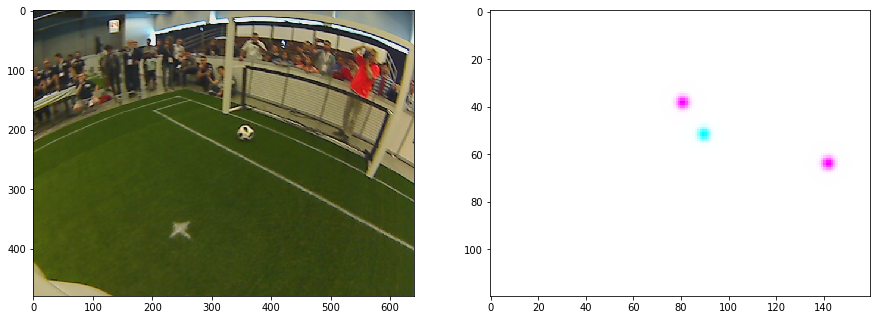

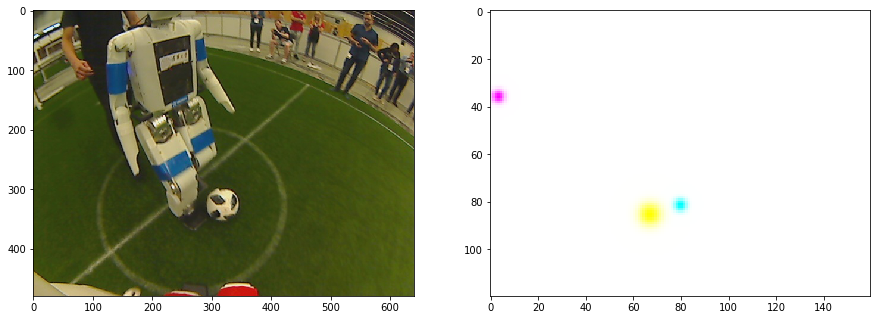

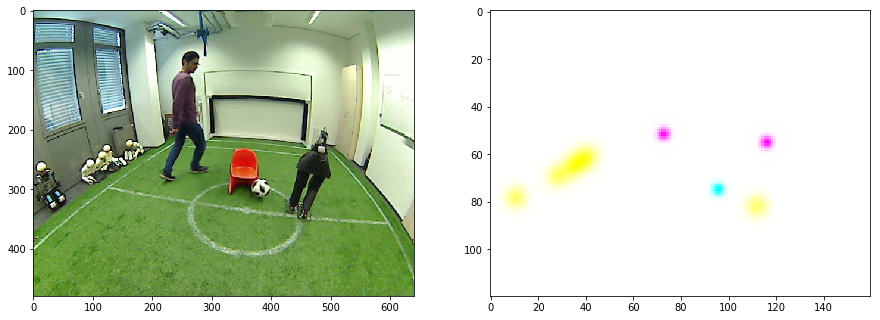

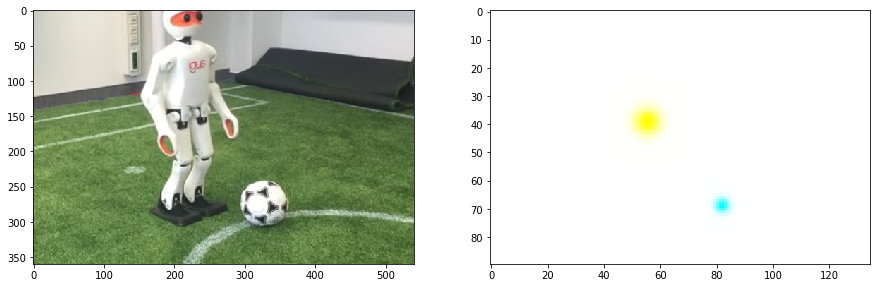

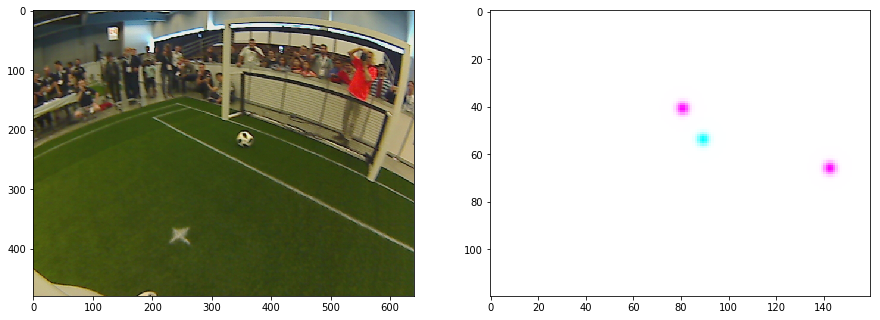

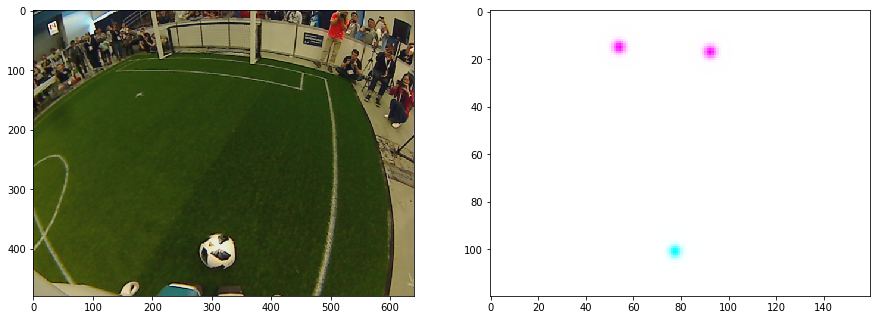

In [4]:
train_data = Blobdataset("/home/santosh/MAS/CUDA_vision/Project/data/blob")
count = 0
for img, label in test_dataset:
    numpy_img = img.numpy().transpose(1,2,0)
    numpy_label = label.numpy().transpose(1,2,0)
#     print(numpy_label)
#     numpy_label = cv2.resize(numpy_label,(numpy_img.shape[1],numpy_img.shape[0]))
#     print(numpy_label.shape)
#     pts = np.where(numpy_label<0.5)
#     numpy_label[pts] = 1.
    plt.figure(1,figsize=(15,10))
    plt.subplot(121)
    plt.imshow(numpy_img)
    plt.subplot(122)
    plt.imshow(numpy_label)
    plt.show()
    count+=1
    if count>5:
        break
    